In [1]:
from pywr.model import Model
from pywr.notebook import draw_graph
from pywr.recorders import TablesRecorder, Recorder
from pywr.parameters import IndexParameter, Parameter, load_parameter
import tables
import pandas
import numpy as np
import os
from MAIPO_parameters import *
from MAIPO_searcher import *

import warnings
warnings.filterwarnings('ignore', category=tables.NaturalNameWarning)

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = "data"
OUTPUT_DIR = "outputs/sim_AGU"

In [7]:
m = Model.load("sc_MAIPO_sim_AGU.json")
draw_graph(m)

Error loading component Total Contracts Made


KeyError: 'thresholds'

In [9]:
m.run()

Model executed 15 scenarios in 10.7 seconds, running at 3374.5 timesteps per second.

In [10]:
from pywr.parameters import IndexParameter, Parameter, load_parameter
from pywr.recorders import Recorder, load_recorder, NodeRecorder, AggregatedRecorder
from pywr.recorders.events import EventRecorder, EventDurationRecorder
import numpy as np
import pandas


class FakeYearIndexParameter(IndexParameter):
    """
        Spanish:
        Clasifica una fecha cualquiera, situandola en alguno de los 6 periodos de planes de desarrollo
        Entrega un entero entre 0 y 7 donde 0 es antes de la semana 14 del 2020 y de 1 a 7 es segun PD

        English:
        Classify any date, placing it in one of the 6 periods of development plans
        Returns an integer between 0 and 7 where 0 is before week 14 of 2020 and 1 to 7 is according to PD.
    """
    def __init__(self, model, dates, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.dates = dates

    def index(self, timestep, scenario_index):

        for i, date in enumerate(self.dates):
            if timestep.datetime < date:
                return i
        else:
            raise ValueError('Simulation date "{}" is at or beyond final date "{}"'.format(timestep.datetime, self.dates[-1]))

    @classmethod
    def load(cls, model, data):

        dates = [pandas.to_datetime(d) for d in data.pop("dates")]
        return cls(model, dates, **data)
FakeYearIndexParameter.register()


class StickyTrigger(Parameter):
    """
        Spanish:
        Evalua si esta activo el contrato en esos 6 meses especificos. En caso de estarlo, entrega el valor del contrato

        English:
        Evaluate if the contract is active in those 6 specific months. If so, deliver the value of the contract

    """

    def __init__(self, model, storage_node, thresholds, contracts, **kwargs):
            super().__init__(model, **kwargs)
            for param in thresholds.values():
                param.parents.add(self)
            self.thresholds = thresholds

            for param in contracts.values():
                param.parents.add(self)
            self.contracts = contracts
            self.storage_node = storage_node

          # Internal state
            self._outcome = 0  # default not triggered
            self._last_week_evaluated = None
            self._last_year_evaluated = None

    def value(self, ts, si):
            week_no = ts.index % 52
            week_no += 1
            year_no = ts.index // 52
            year = self.model.timestepper.start.year + year_no

            try:
                            threshold_parameter = self.thresholds[week_no]
            except KeyError:
                return self._outcome
            else:
                # There is a threshold for this week
                if self._last_week_evaluated == week_no and self._last_year_evaluated == year:
                    # We've already evaluated this week
                                return self._outcome
                else:
                                # We need to evaluate the trigger for this threshold
                                current_volume = self.storage_node.volume[si.global_id]
                                threshold = threshold_parameter.get_value(si)
                                if current_volume < threshold:
                                                contract_parameter = self.contracts[week_no]
                                                contract_size = contract_parameter.get_value(si)
                                                self._outcome = contract_size
                                else:
                                                self._outcome = 0
                                self._last_week_evaluated = week_no
                                self._last_year_evaluated = year
                                return self._outcome

    @classmethod
    def load(cls, model, data):
        thresholds = {int(k): load_parameter(model, v) for k, v in data.pop('thresholds').items()}
        contracts = {int(k): load_parameter(model, v) for k, v in data.pop('contracts').items()}
        storage_node = model._get_node_from_ref(model, data.pop('storage_node'))
        return cls(model, storage_node, thresholds, contracts)
StickyTrigger.register()


class AccumulatedIndexedArrayParameter(Parameter):
    """
        Spanish:
        Guarda la cantidad de derechos comprados en los planes de desarrollo anteriores

        English:
        Save the amount of rights purchased in previous development plans

    """
    def __init__(self, model, index_parameter, params, **kwargs):
        super().__init__(model, **kwargs)
        assert(isinstance(index_parameter, IndexParameter))
        self.index_parameter = index_parameter
        self.children.add(index_parameter)

        self.params = []
        for p in params:
            if not isinstance(p, Parameter):
                from pywr.parameters import ConstantParameter
                p = ConstantParameter(model, p)
            self.params.append(p)

        for param in self.params:
            self.children.add(param)
        self.children.add(index_parameter)

    def value(self, timestep, scenario_index):
        """Returns the value of the Parameter at the current index"""
        index = self.index_parameter.get_index(scenario_index)
        value = 0
        for i in range(index):
            value += self.params[i].get_value(scenario_index)
        return value

    @classmethod
    def load(cls, model, data):
        index_parameter = load_parameter(model, data.pop("index_parameter"))
        try:
            parameters = data.pop("params")
        except KeyError:
            parameters = data.pop("parameters")
        parameters = [load_parameter(model, parameter_data) for parameter_data in parameters]
        return cls(model, index_parameter, parameters, **data)
AccumulatedIndexedArrayParameter.register()

class ReservoirCostRecorder (Recorder):
    """
        Spanish:
        Guarda el costo de construir el embalse, dependiendo de cuando se construye, considerando un periodo de DP antes

        English:
        Saves the cost of building the reservoir, depending on when it is built, considering a DP period before
    """

    def __init__(self, model, construction_dp, capacity, unit_costs, discount_rate, fixed_cost, **kwargs):
        super().__init__(model, **kwargs)
        self.construction_dp = construction_dp
        self.capacity = capacity
        self.children.add(construction_dp)
        self.children.add(capacity)
        self.discount_rate = discount_rate
        self._costs = None

    def finish(self):

        costs = np.zeros(len(self.model.scenarios.combinations))

        capacity = self.capacity.get_all_values()
        construction_dp = np.floor(self.construction_dp.get_all_values())

        for i in range(len(costs)):
            if construction_dp[i] > 6:
                costs[i] = 0
            else:
                decision_dp = int(construction_dp[i]) - 1
                discount_factor = 1 / (1 + self.discount_rate)**((decision_dp-1)*5)
                costs[i] = (335748.31*capacity[i]**0.342)*discount_factor

        self._costs = costs

    def values(self):
        return self._costs


    @classmethod
    def load(cls, model, data):

        construction_dp = load_parameter(model, data.pop("construction_dp"))
        capacity = load_parameter(model, data.pop("capacity"))
        return cls(model, construction_dp, capacity, **data)
ReservoirCostRecorder.register()

class PurchasesCostRecorder (Recorder):
    """
        Spanish:
        Guarda el costo total de todas las compras de derechos

        English:
        Save the total cost of all rights purchases
    """

    def __init__(self, model, purchases_value, meanflow, discount_rate, coeff, **kwargs):
        super().__init__(model, **kwargs)
        self.purchases_value = purchases_value
        self.children.add(purchases_value)
        self.meanflow = meanflow
        self.children.add(meanflow)
        self.coeff = coeff
        self.discount_rate = discount_rate
        self._costs = None

    def finish(self):

        costs = np.zeros(len(self.model.scenarios.combinations))

        start_year = self.model.timestepper.start.year
        mean_flows = self.meanflow.data

        for dp_index, purchase in enumerate(self.purchases_value.params):
            if dp_index == 0:
                continue

            shares = purchase.get_all_values()
            timestep_index = (2020 - start_year)*52 + (dp_index - 1) * 52 * 5
            discount_factor = 1 / (1 + self.discount_rate)**((dp_index-1)*5)

            for i in range(len(costs)):
                mean_flow = mean_flows[timestep_index, i]
                if shares[i] > 0:
                    share_cost = 2.71828182846**(12.46382-0.7639182*np.log(shares[i])+1.516715*np.log(mean_flow))
                else: share_cost = 0
                costs[i] += shares[i] * share_cost * discount_factor

        self._costs = costs

    def values(self):
        return self._costs

    @classmethod
    def load(cls, model, data):

        purchases_value = load_parameter(model, data.pop("purchases"))
        mean_flow = load_recorder(model, data.pop("mean_flow"))
        return cls(model, purchases_value, mean_flow, **data)
PurchasesCostRecorder.register()

class SeasonRollingMeanFlowNodeRecorder(NodeRecorder):
    """Records the mean flow of a Node for the previous N timesteps for a specific season (april to october or october to april)

    Parameters
    ----------
    model : `pywr.core.Model`
    node : `pywr.core.Node`
        The node to record
    timesteps : int
        The number of timesteps to calculate the mean flow for
    name : str (optional)
        The name of the recorder

    """
    def __init__(self, model, node, first_week, last_week, years, **kwargs):
        super().__init__(model, node, **kwargs)
        self.first_week = first_week
        self.last_week = last_week
        self.years = years
        self.data = None

    def reset(self):
        super().reset()
        self.position = 0
        self.data = np.empty([len(self.model.timestepper), len(self.model.scenarios.combinations)])
        self._memory = np.zeros([len(self.model.scenarios.combinations), (self.last_week-self.first_week)*self.years])
        self.passed_weeks = 0

    def after(self):
        # calculates the week
        ts = self.model.timestepper.current
        week_no = ts.index % 52
        week_no += 1
        year_no = ts.index // 52
        year = self.model.timestepper.start.year + year_no
        if self.first_week <= week_no < self.last_week:
            # save today's flow
            for i in range(0, self._memory.shape[0]):
                self._memory[i, self.position] = self.node.flow[i]
            self.passed_weeks += 1
            # calculate the mean flow
            n = self._memory.shape[1]
            if self.passed_weeks < n:
                n = self.passed_weeks
            # save the mean flow
            mean_flow = np.mean(self._memory[:, 0:n], axis=1)
            self.data[ts.index, :] = mean_flow
            # prepare for the next timestep
            self.position += 1
            if self.position >= self._memory.shape[1]:
                self.position = 0

    @classmethod
    def load(cls, model, data):
        node = model._get_node_from_ref(model, data.pop("node"))
        return cls(model, node, **data)

SeasonRollingMeanFlowNodeRecorder.register()

class ContractCostRecorder (Recorder):
    """
        Spanish:
        Entrega el costo total relativo a los contratos segun fueron activados

        English:
        Delivers the total cost relative to the contracts as they were activated
    """
    def __init__(self, model, contract_value, meanflow, purchases_value, discount_rate, max_cost, gradient, coeff, week_no, total_shares = 8133, **kwargs):
        super().__init__(model, **kwargs)
        self.meanflow = meanflow
        self.children.add(meanflow)
        self.contract_value = contract_value
        self.children.add(contract_value)
        self.purchases_value = purchases_value
        self.children.add(purchases_value)
        self.discount_rate = discount_rate
        self.max_cost = max_cost
        self.gradient = gradient
        self.coeff = coeff
        self.week_no = week_no
        self.total_shares = total_shares
        self._costs = None

    def reset(self):
        self._costs = np.zeros(len(self.model.scenarios.combinations))

    def after(self):
        # calculates the week
        ts = self.model.timestepper.current
        week_no = ts.index % 52
        week_no += 1
        year_no = ts.index // 52
        #year = self.model.timestepper.start.year + year_no

        if week_no != self.week_no:
            return

        costs = self._costs
        shares = self.contract_value.get_all_values()
        purchases = self.purchases_value.get_all_values()
        mean_flows = self.meanflow.data
        m = self.gradient
        n = self.max_cost

        discount_factor = 1 / (1 + self.discount_rate)**(year_no)

        interruptor = 1 #por mientras

        for i in range(len(costs)):
            if interruptor == 1:
                c = 262.273/0.08
                costs[i] += c*discount_factor
            else:
                f = mean_flows[ts.index, i]*26
                K = shares[i]
                p = purchases[i]
                c = (m*K*f/8133 * (f*K/(2*8133) + n/m - (8133-1917-p)*f/8133))
                costs[i] += c*discount_factor


    def values(self):
        return self._costs

    @classmethod
    def load(cls, model, data):
        meanflow = load_recorder(model, data.pop("mean_flow"))
        contract_value = load_parameter(model, data.pop("contract"))
        purchases_value = load_parameter(model, data.pop("purchases"))
        return cls(model, contract_value, meanflow, purchases_value, **data)
ContractCostRecorder.register()

def CustomizedAggregation(model, weights):
# Apply weighted aggregation function
    def weighted_agg_func(values):
        return np.dot(weights, values)
    model.recorders['deficit PT1'].agg_func = weighted_agg_func

    threshold = model.recorders["InstanstaneousDeficit"]
    events = EventRecorder(model, threshold, name = "deficit_event")
    duration = EventDurationRecorder(model, events, name = "Max Deficit Duration", recorder_agg_func = "max", agg_func = "mean", is_objective = "min")

class MaximumDeficitNodeRecorder(NodeRecorder):
    """
    Recorder the maximum difference between modelled flow and max_flow for a Node
    """
    def reset(self):
        self._values = np.zeros(len(self.model.scenarios.combinations))

    def after(self):
        ts = self.model.timestepper.current
        days = self.model.timestepper.current.days
        node = self.node
        values = self._values

        for scenario_index in self.model.scenarios.combinations:
            max_flow = node.get_max_flow(scenario_index)
            deficit = (max_flow - node.flow[scenario_index.global_id])*days
            if deficit > values[scenario_index.global_id]:
                values[scenario_index.global_id] = deficit

    def values(self):
        return self._values
MaximumDeficitNodeRecorder.register()


class InstantaneousDeficictNodeRecorder(NodeRecorder):
    """
    Recorder the maximum difference between modelled flow and max_flow for a Node
    """
    def reset(self):
        self._values = np.zeros(len(self.model.scenarios.combinations))

    def after(self):
        ts = self.model.timestepper.current
        days = self.model.timestepper.current.days
        node = self.node
        values = self._values

        for scenario_index in self.model.scenarios.combinations:
            max_flow = node.get_max_flow(scenario_index)
            deficit = (max_flow - node.flow[scenario_index.global_id])*days
            if deficit < 1e-4:
                deficit = 0
            values[scenario_index.global_id] = deficit

    def values(self):
        return self._values
InstantaneousDeficictNodeRecorder.register()


class ShortageCostRecorder(Recorder):
    """
    Saves domestic water shortage costs depending on urban water deficits
    """

    def __init__(self, model, unit_cost, deficits_value, discount_rate, **kwargs):
        super().__init__(model, **kwargs)
        self.unit_cost = unit_cost
        self.deficits_value = deficits_value
        self.children.add(deficits_value)
        self.discount_rate = discount_rate
        self._costs = None

    def reset(self):
        self._costs = np.zeros(len(self.model.scenarios.combinations))

    def after(self):
        ts = self.model.timestepper.current
        year_no = ts.index // 52

        costs = self._costs
        deficits = self.deficits_value.get_all_values()

        discount_factor = 1 / (1 + self.discount_rate)**(year_no)

        for i in range(len(costs)):
            d = deficits[i]
            c = self.unit_cost*d
            costs[i] += c*discount_factor

    def values(self):
        return self._costs


ShortageCostRecorder.register()


class PolicyTrigger(Parameter):
    """
        English:
        Evaluate if the contract is active in those 6 specific months. If so, deliver the value of the contract

    """

    def __init__(self, model, drought_status, thresholds, contracts, **kwargs):
        super().__init__(model, **kwargs)
        for param in thresholds.values():
            param.parents.add(self)
        self.thresholds = thresholds

        for param in contracts.values():
            param.parents.add(self)
        self.contracts = contracts
        self.drought_status = drought_status

        # Internal state
        #self._outcome = 0  # default not triggered
        #self._last_week_evaluated = None
        #self._last_year_evaluated = None

    def setup(self):
        # allocate an array to hold the parameter state
        super().setup()
        num_scenarios = len(self.model.scenarios.combinations)
        self._outcome = np.empty([num_scenarios], np.float64)
        self._last_week_evaluated = np.empty([num_scenarios], np.int64)
        self._last_year_evaluated = np.empty([num_scenarios], np.int64)


    def reset(self):
        # reset the amount remaining in all states to the initial value
        self._outcome[...] = 0
        self._last_week_evaluated[...] = -1
        self._last_year_evaluated[...] = -1

    def value(self, timestep, scenario_index):
        gid = scenario_index.global_id
        week_no = timestep.index % 52
        week_no += 1
        year_no = timestep.index // 52
        year = self.model.timestepper.start.year + year_no

        try:
            threshold_parameter = self.thresholds[week_no]
        except KeyError:
            return self._outcome[gid]
        else:
            # There is a threshold for this week
            if self._last_week_evaluated[gid] == week_no and self._last_year_evaluated[gid] == year:
                # We've already evaluated this week
                return self._outcome[gid]
            else:
                # We need to evaluate the trigger for this threshold
                current_drought = self.drought_status.value(timestep, scenario_index)

                # threshold = threshold_parameter.get_value(scenario_index)
                threshold = threshold_parameter.value(timestep, scenario_index)
                if current_drought < threshold:
                    contract_parameter = self.contracts[week_no]
                    contract_size = contract_parameter.get_value(scenario_index)
                    self._outcome[gid] = contract_size
                else:
                    self._outcome[gid] = 0
                self._last_week_evaluated[gid] = week_no
                self._last_year_evaluated[gid] = year
                return self._outcome[gid]

    @classmethod
    def load(cls, model, data):
        thresholds = {int(k): load_parameter(model, v) for k, v in data.pop('thresholds').items()}
        contracts = {int(k): load_parameter(model, v) for k, v in data.pop('contracts').items()}
        drought_status = load_parameter(model, 'drought_index')
        return cls(model, drought_status, thresholds, contracts)
PolicyTrigger.register()



In [11]:
m = Model.load("sc_MAIPO_sim_AGU.json")

TablesRecorder(m, "outputs/flows.h5", filter_kwds={"complib": "zlib", "complevel": 5 }, parameters= ["contract_value", "DP_index", "purchases_value", "Maipo_max_volume"])

weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
CustomizedAggregation(m, weights)


m.run()


data = {}
values = {}
for r in m.recorders:

    rdata = {
        'class': r.__class__.__name__,
    }

    try:
        rdata['value'] = r.aggregated_value()
    except NotImplementedError:
        pass

    try:
        rdata['node'] = r.node.name
    except AttributeError:
        pass

    try:
        values[r.name] = list(r.values())
    except NotImplementedError:
        pass

    if len(rdata) > 1:
        data[r.name] = rdata

writer = pandas.ExcelWriter('outputs/sim_AGU/metrics.xlsx', engine = 'xlsxwriter')
metrics = pandas.DataFrame(data).T
metrics.to_csv("outputs/sim_AGU/metrics.csv")
metrics.to_excel(writer, 'aggregated')
scenario_values = pandas.DataFrame(values).T
scenario_values.to_excel(writer, 'scenarios')
# writer.save() - note: save has been depreciated. Use close() instead.
writer.close()

/var/folders/dy/9kvsht2j6tq450pxdxt43wnh0000gq/T/ipykernel_95633/3376636228.py:1: DeprecationWarning: `RollingMeanFlowNodeRecorder` has been deprecated in favour of `RollingMeanFlowNodeParameter`. If you need to record the value use a recorder capable of recording an arbitrary parameter (e.g. `NumpyArrayParameterRecorder`)
  m = Model.load("sc_MAIPO_sim_AGU.json")
/var/folders/dy/9kvsht2j6tq450pxdxt43wnh0000gq/T/ipykernel_95633/3903369732.py:302: DeprecationWarning: Use of `_get_node_from_ref` is deprecated and will be removed in the future.Please use `model.nodes[node_name] instead.
  node = model._get_node_from_ref(model, data.pop("node"))


/var/folders/dy/9kvsht2j6tq450pxdxt43wnh0000gq/T/ipykernel_95633/3291930931.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, figsize=(12, 4))


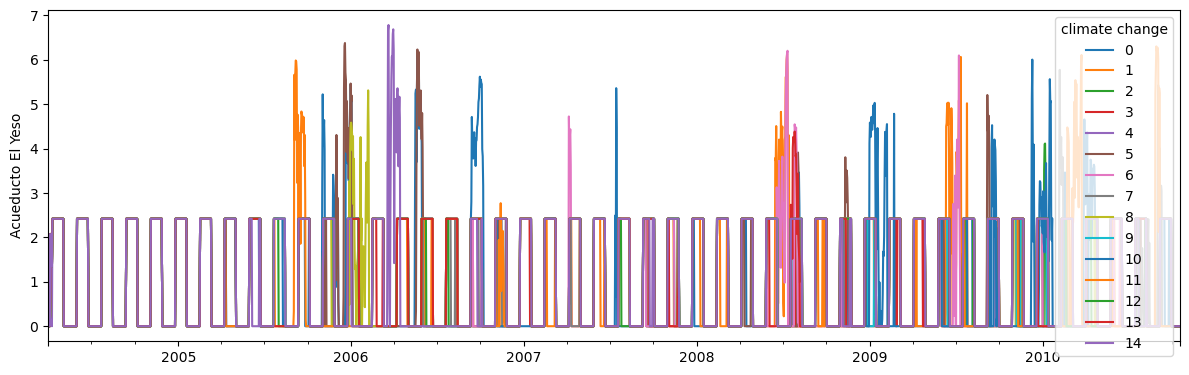

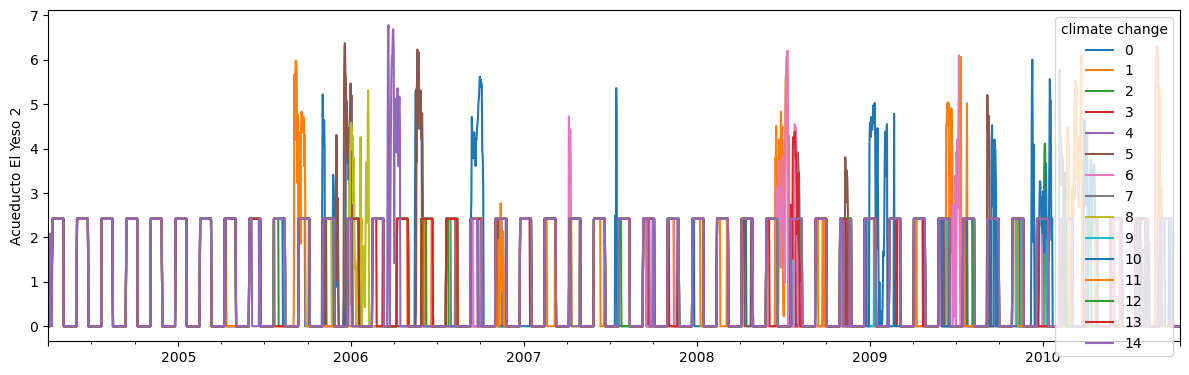

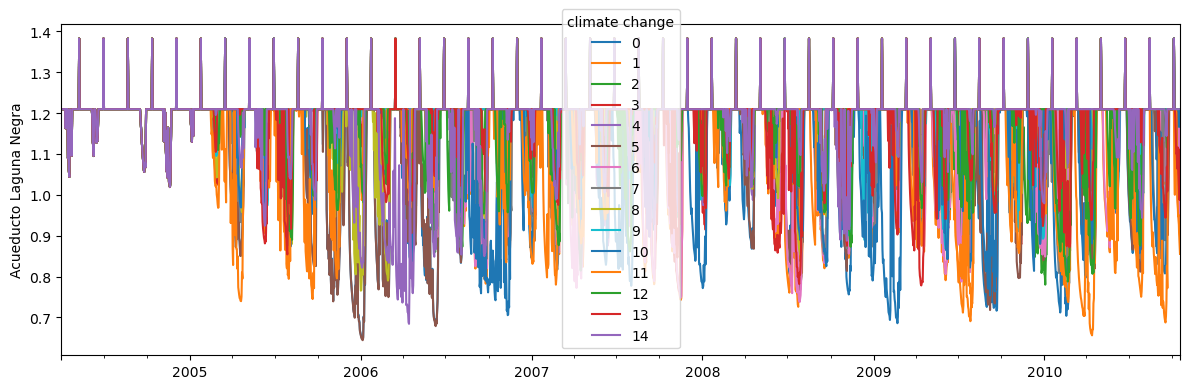

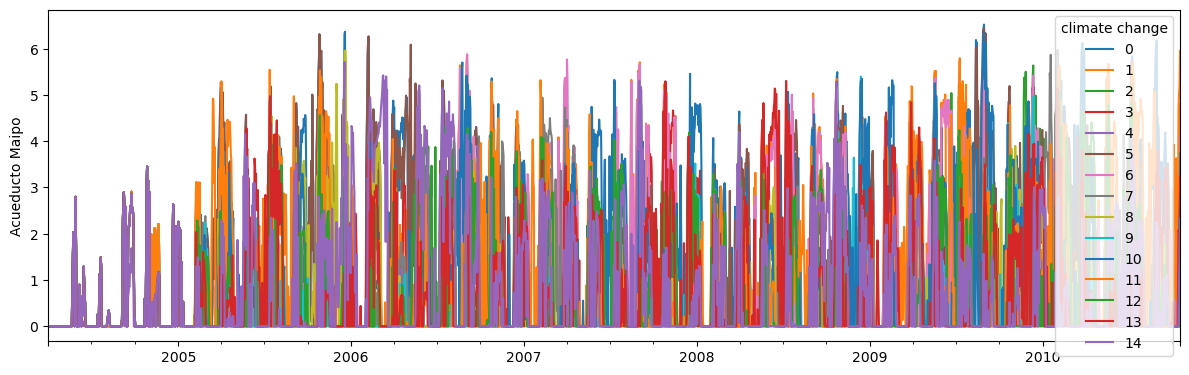

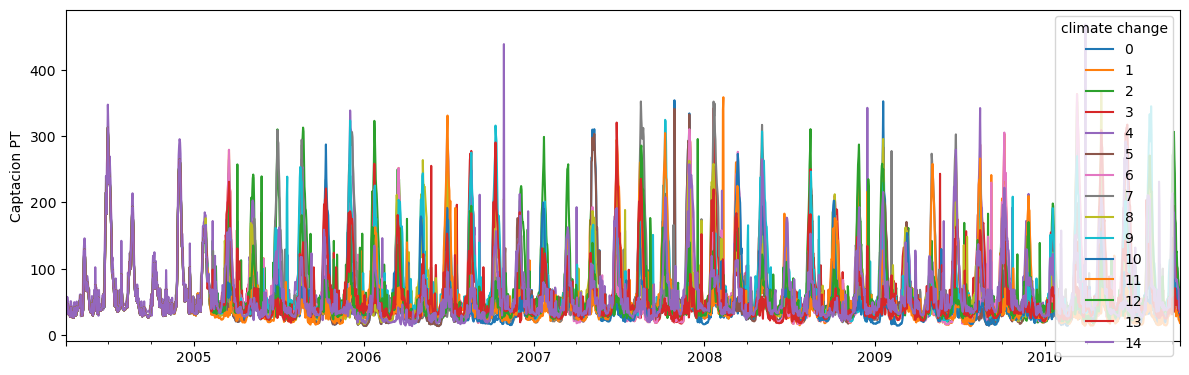

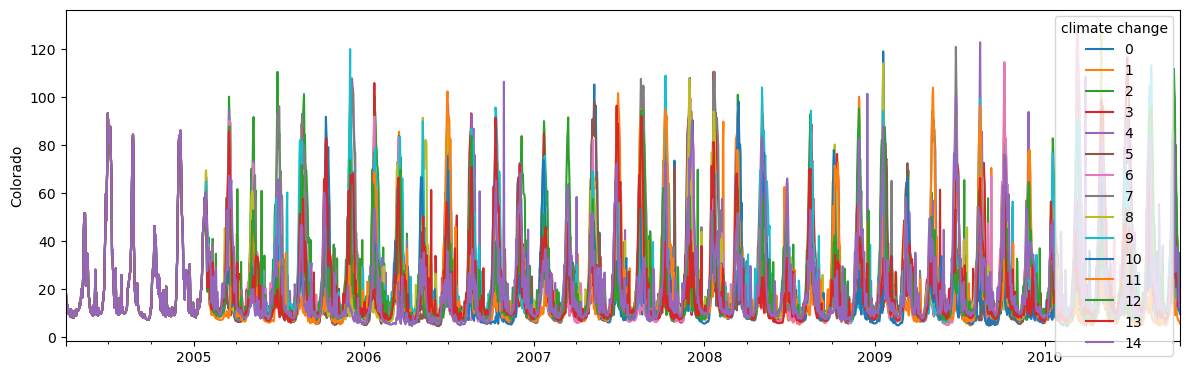

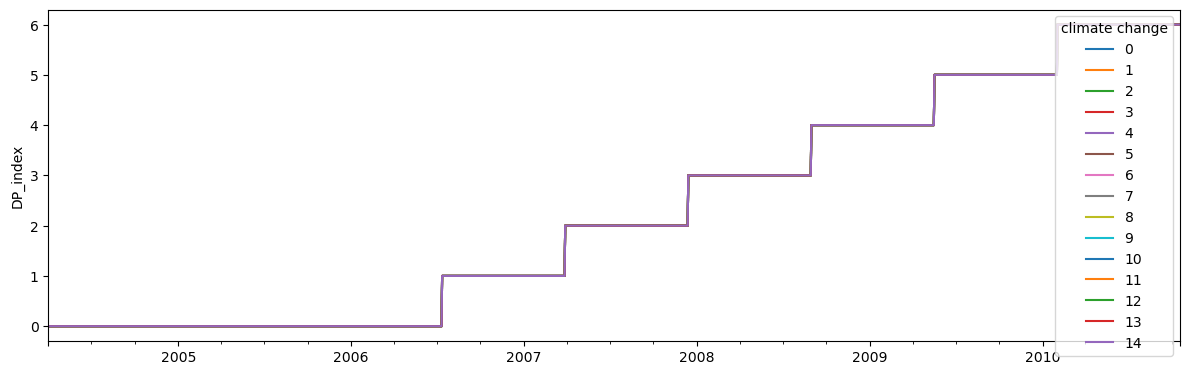

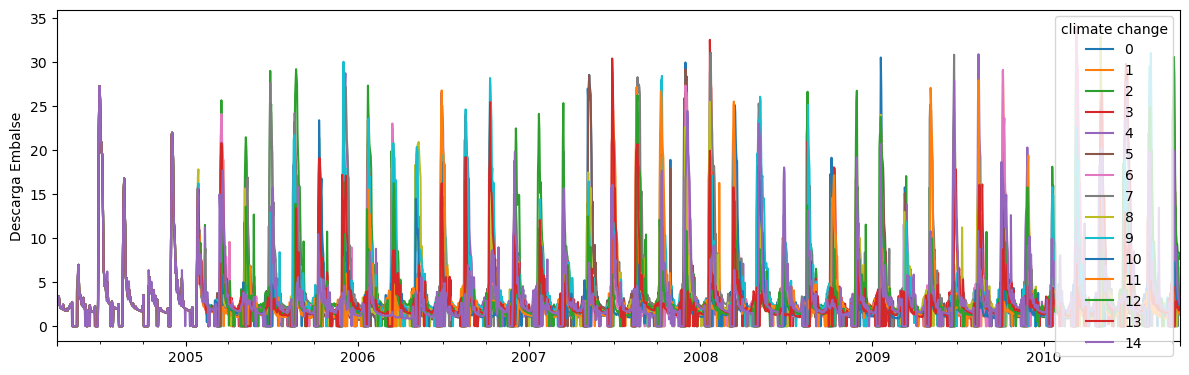

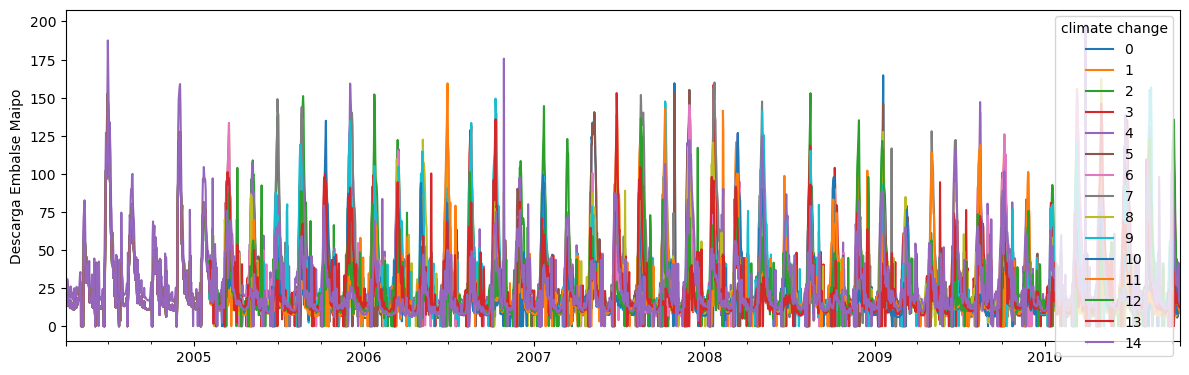

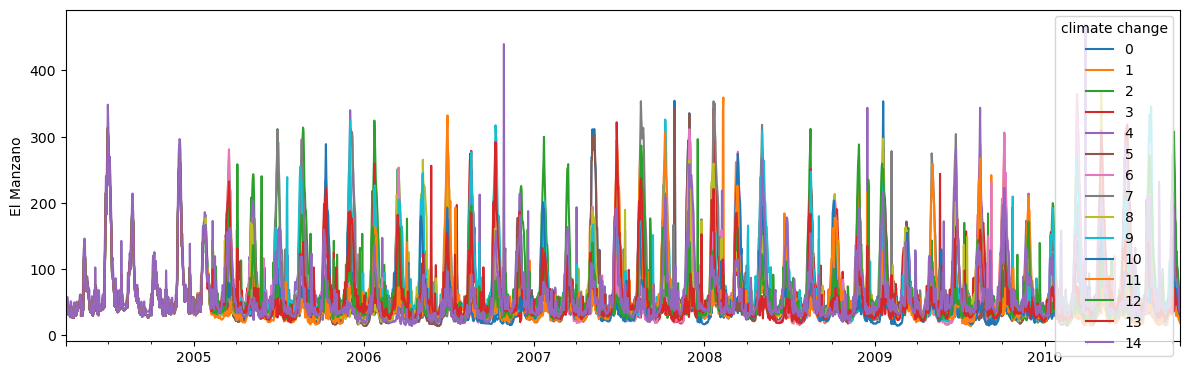

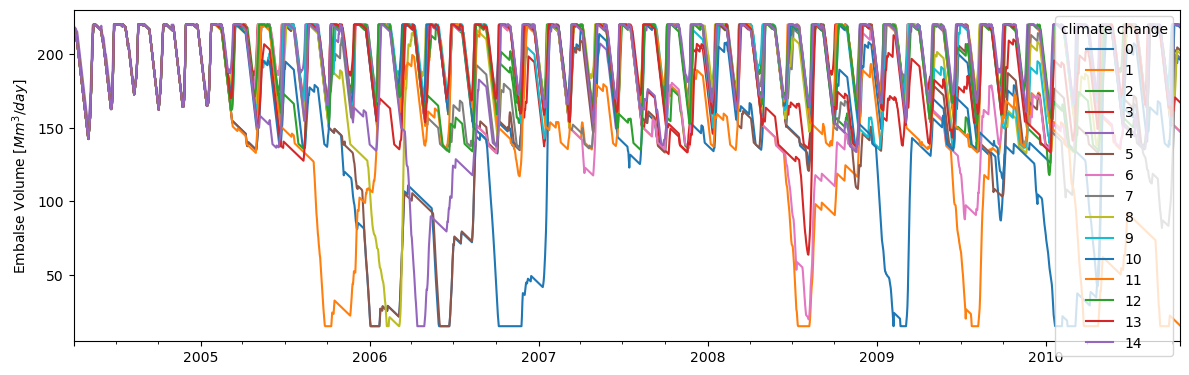

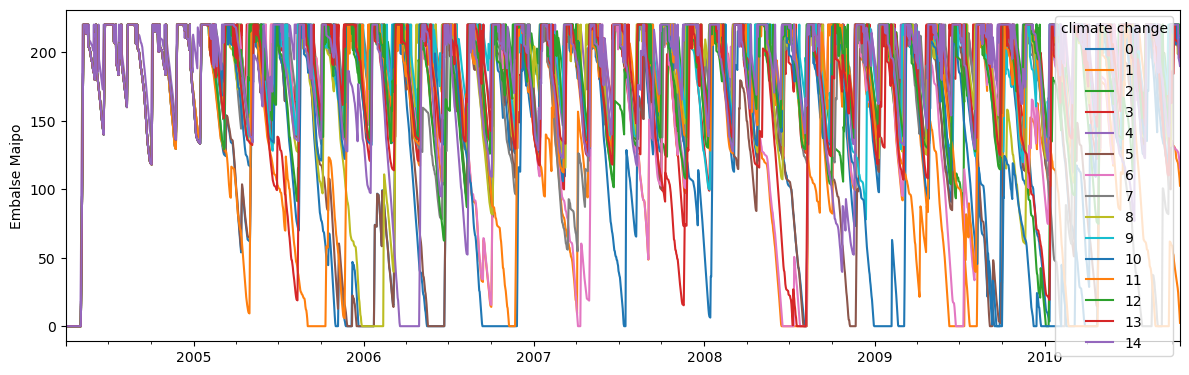

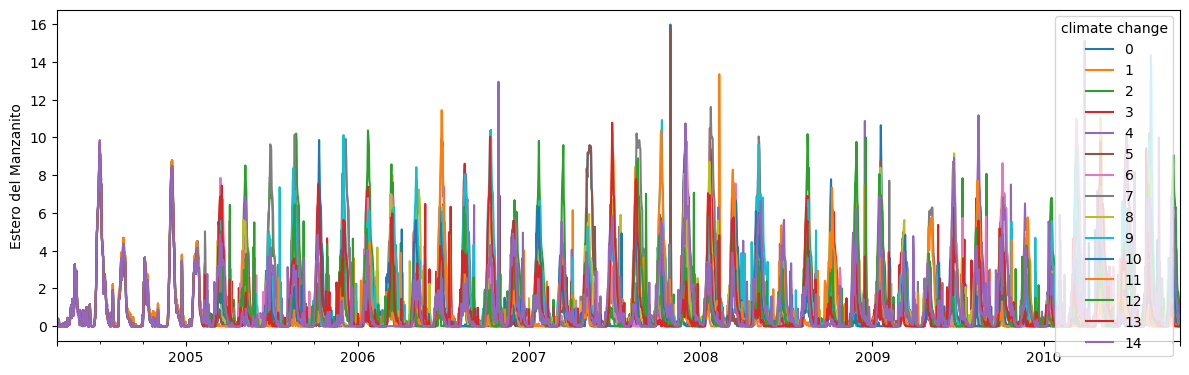

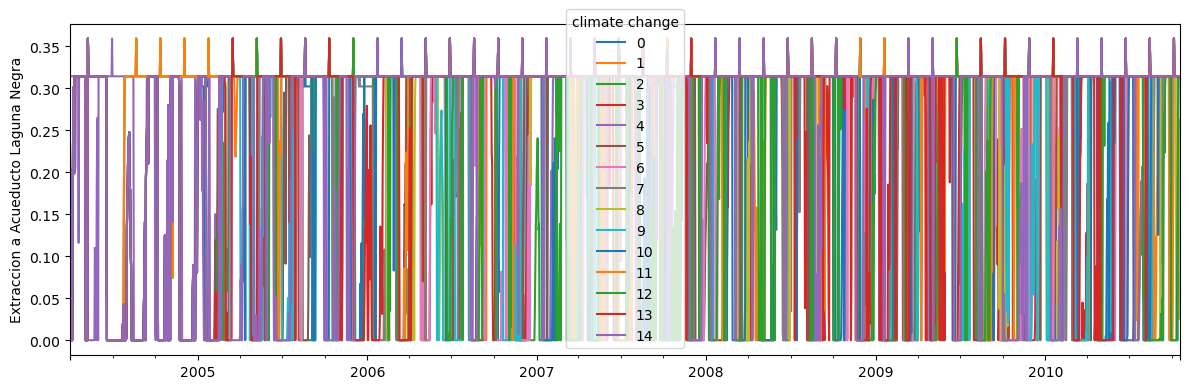

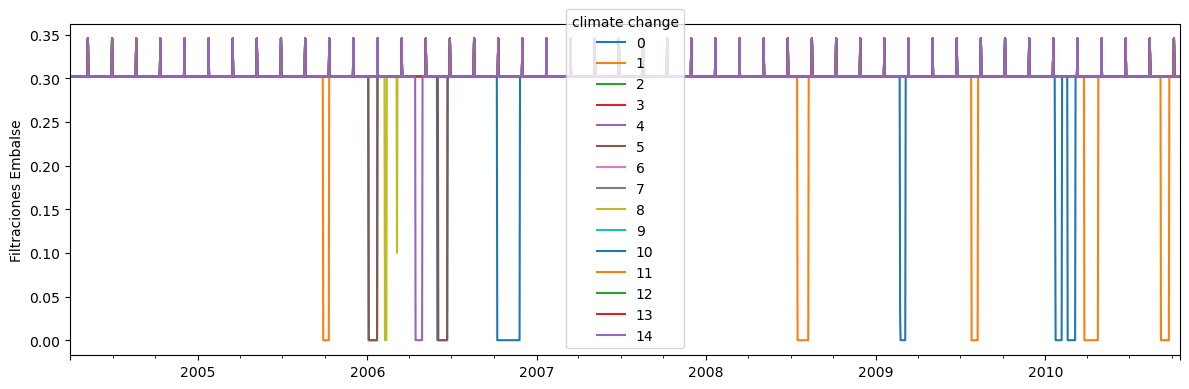

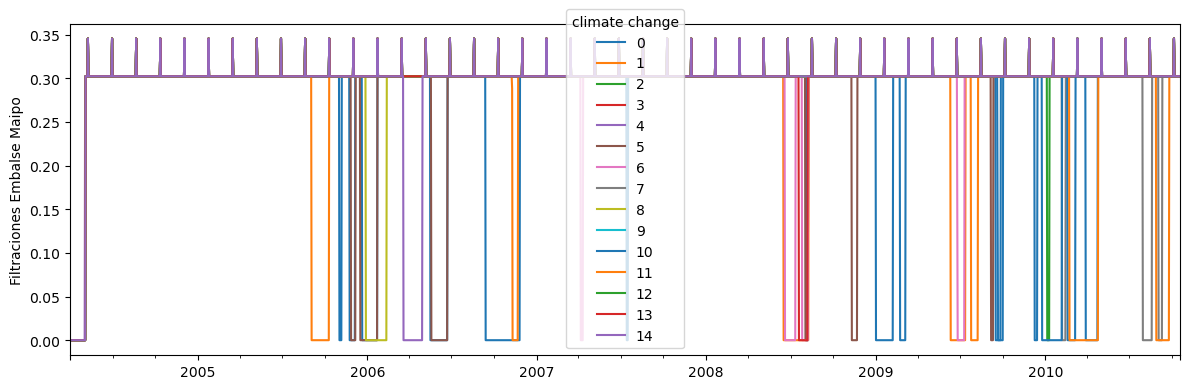

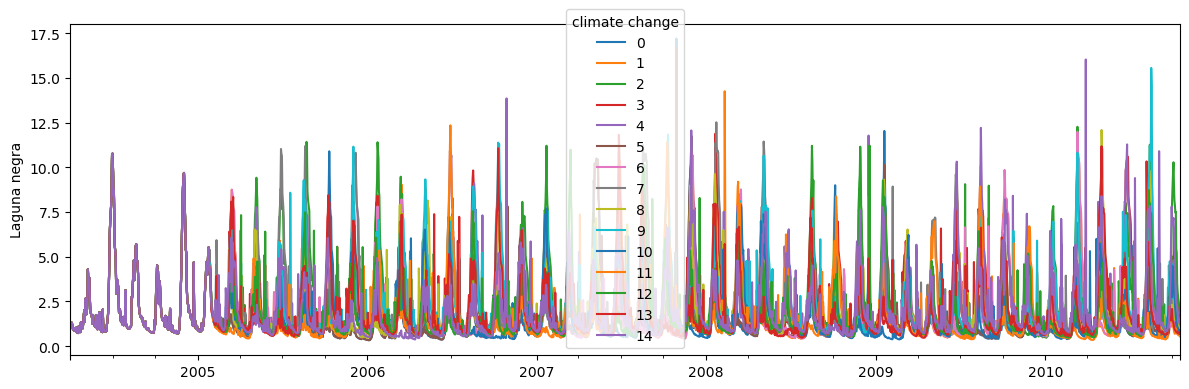

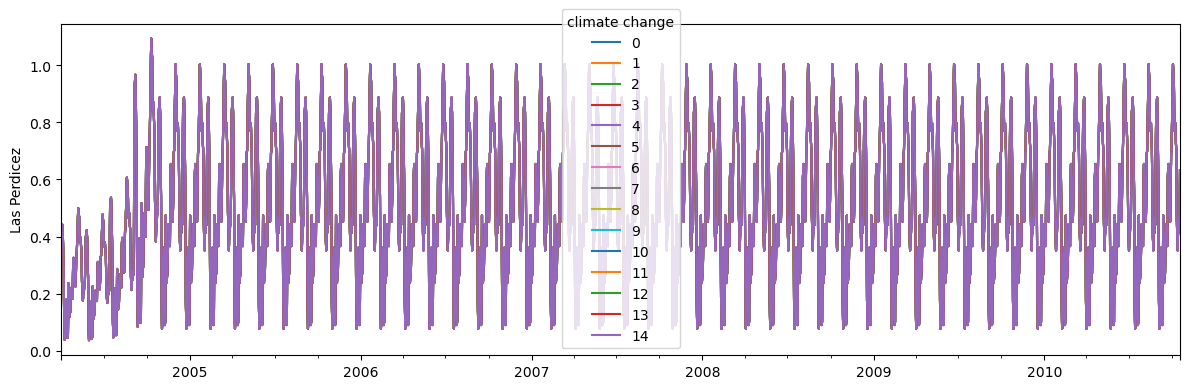

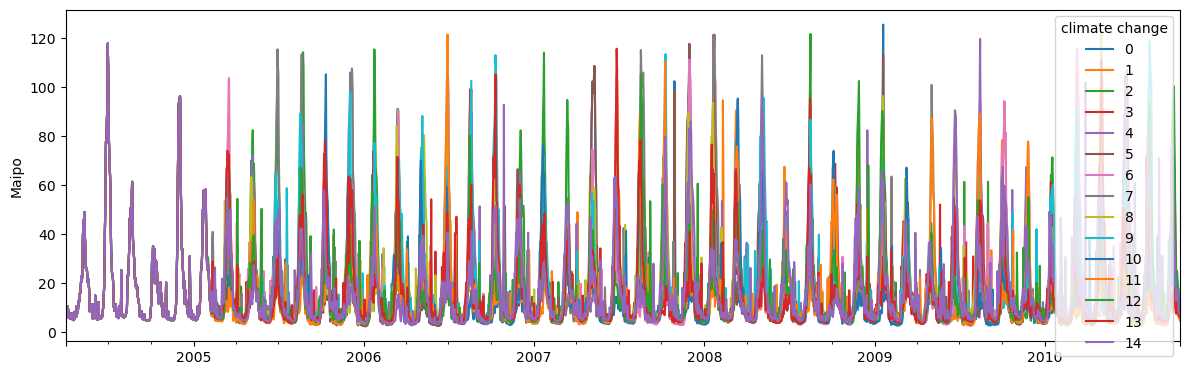

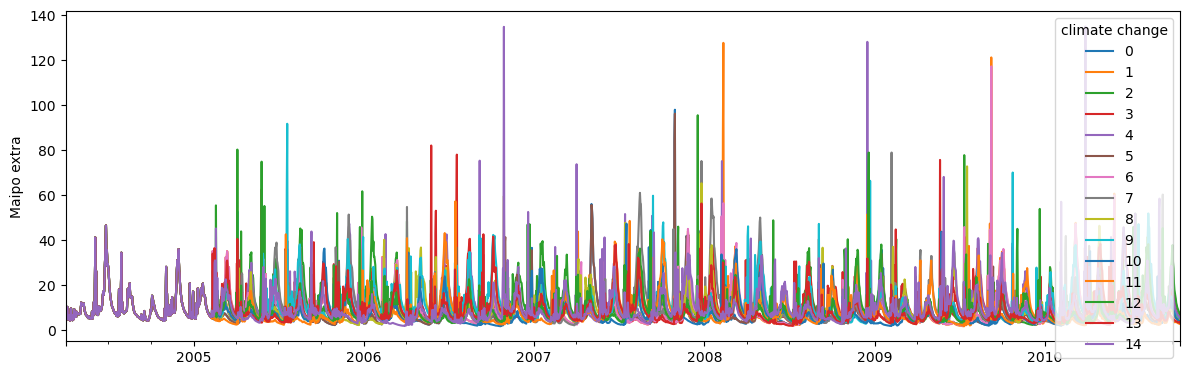

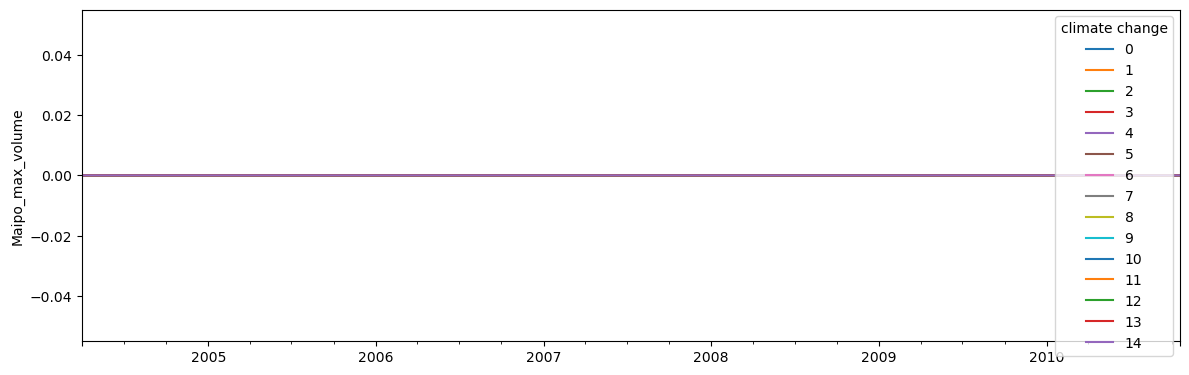

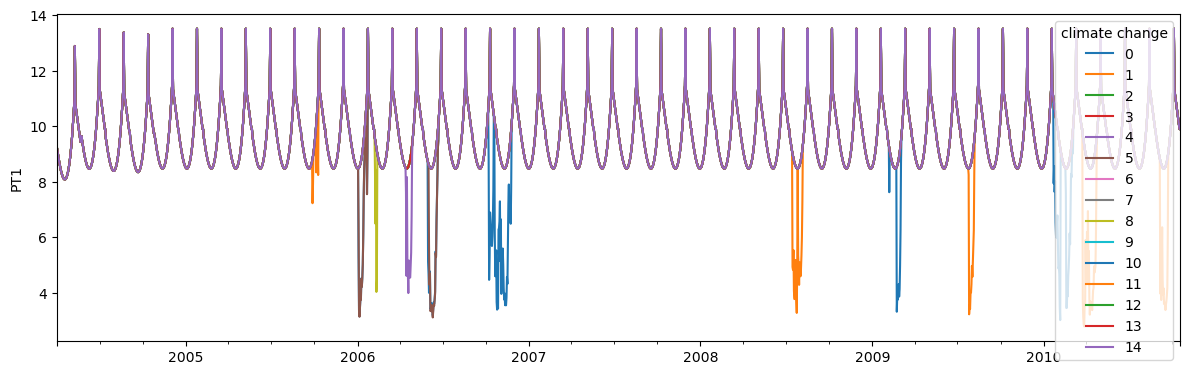

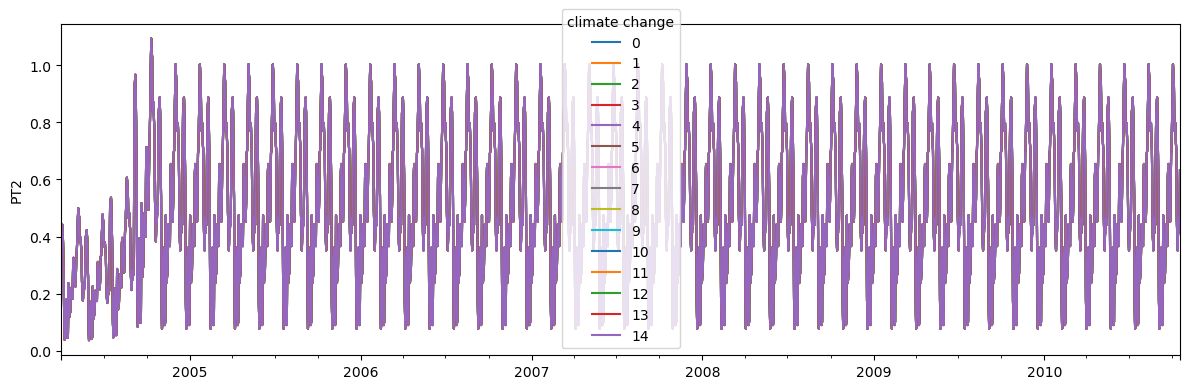

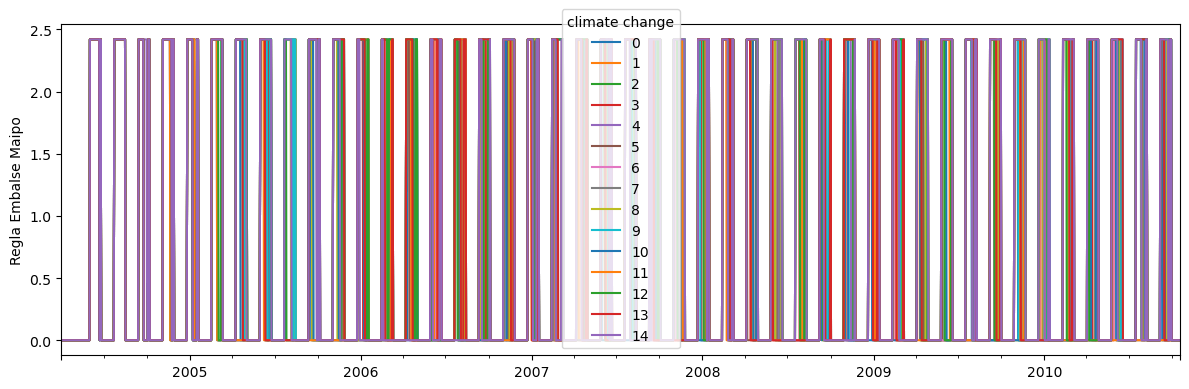

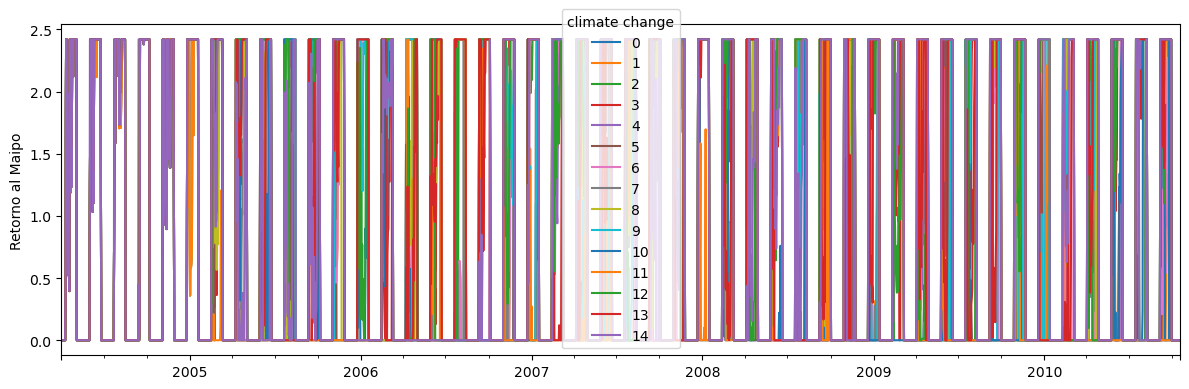

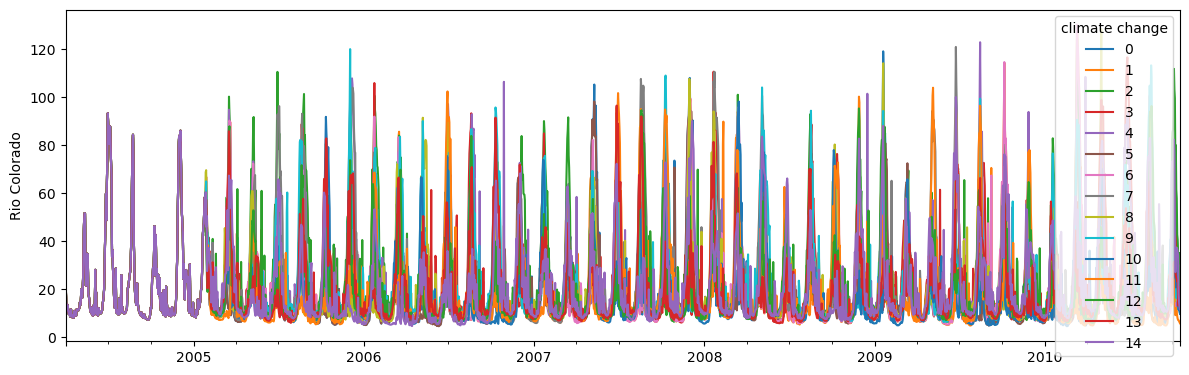

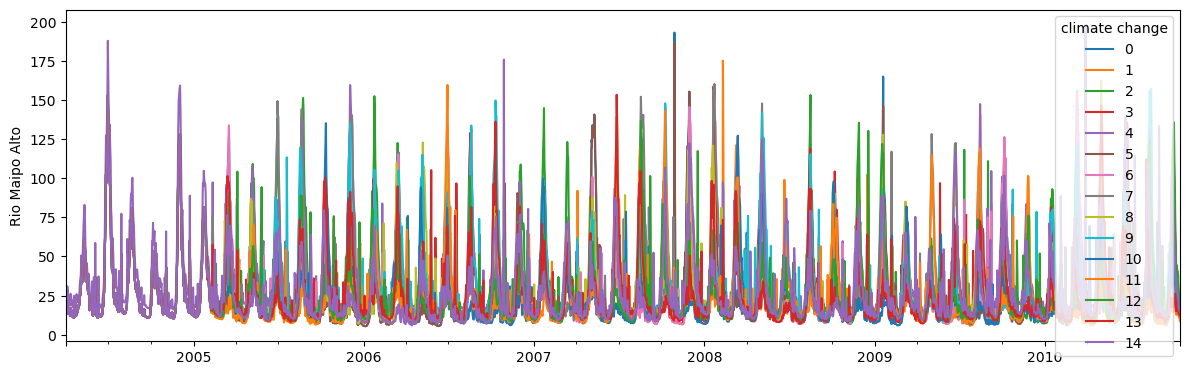

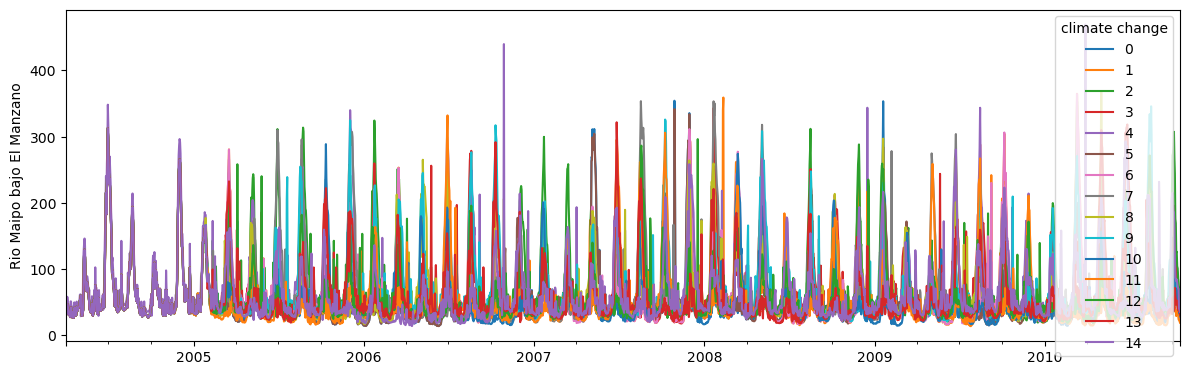

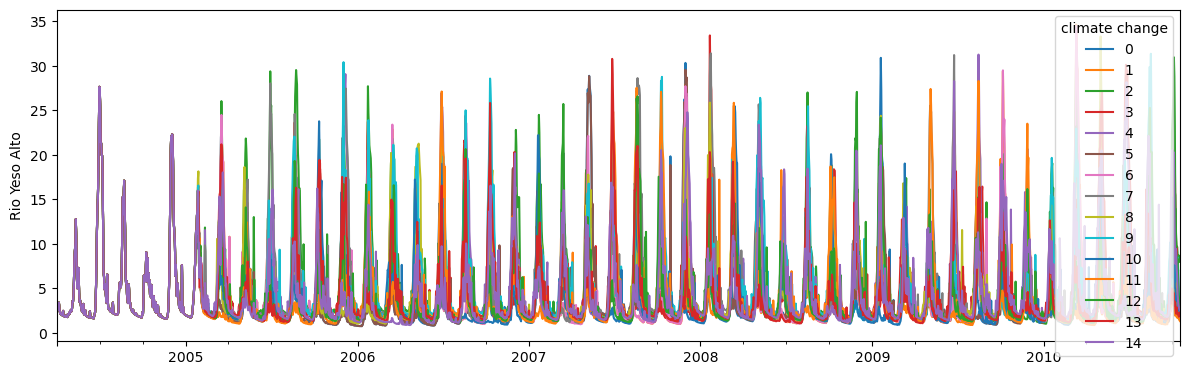

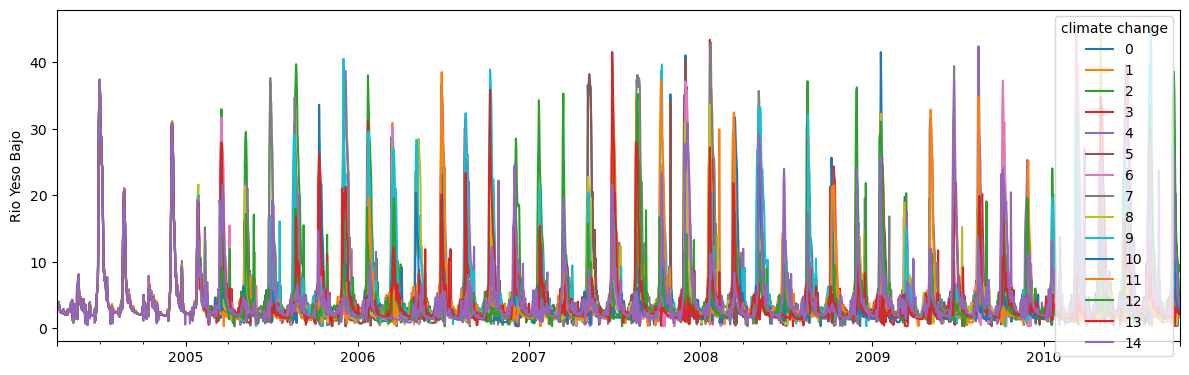

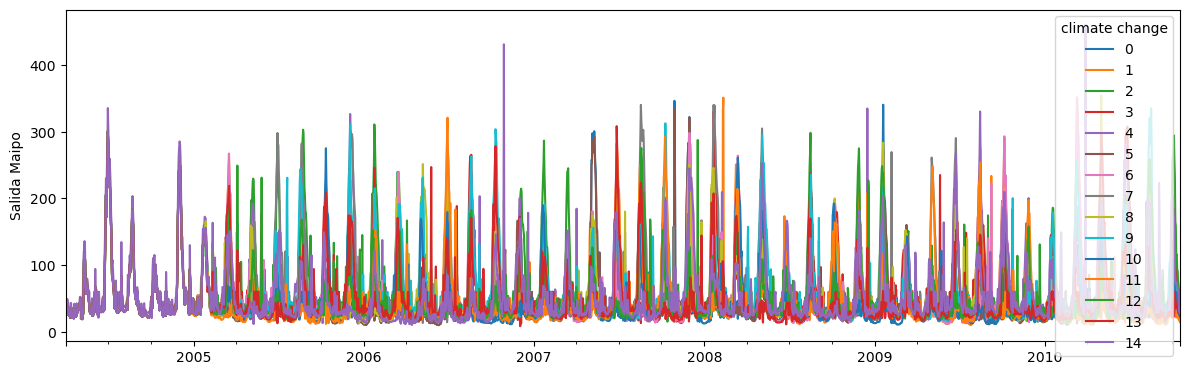

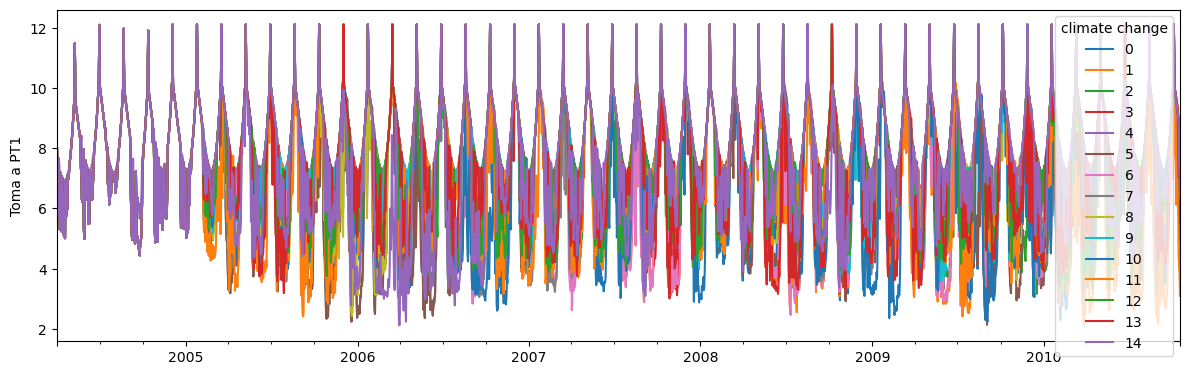

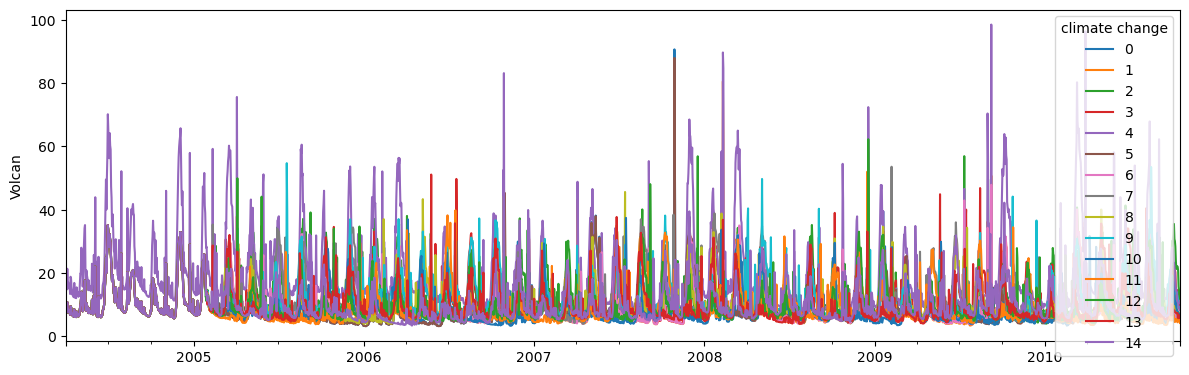

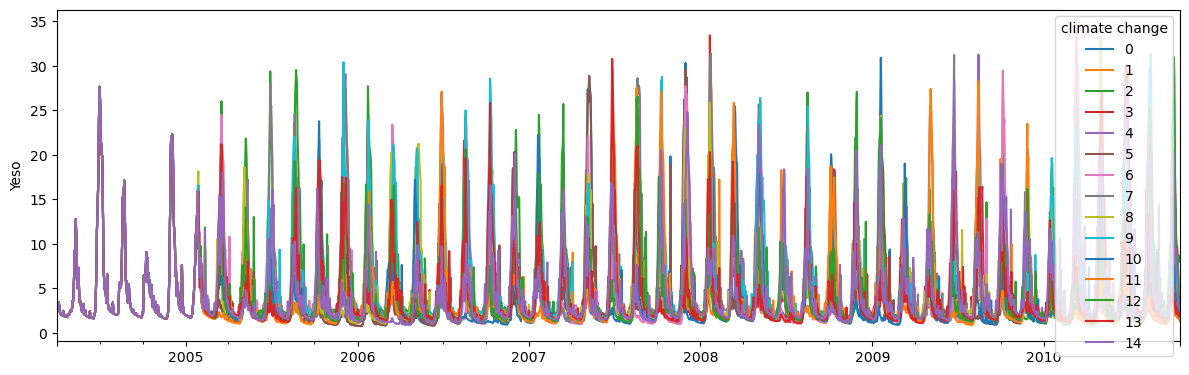

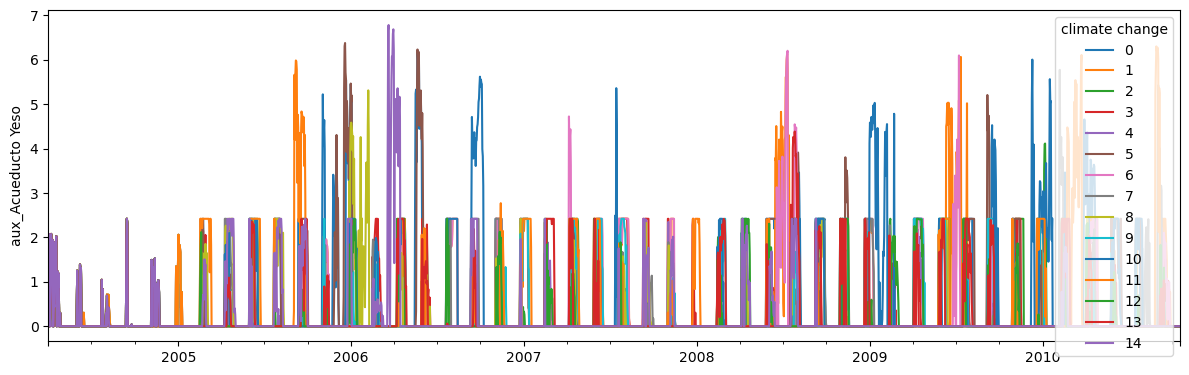

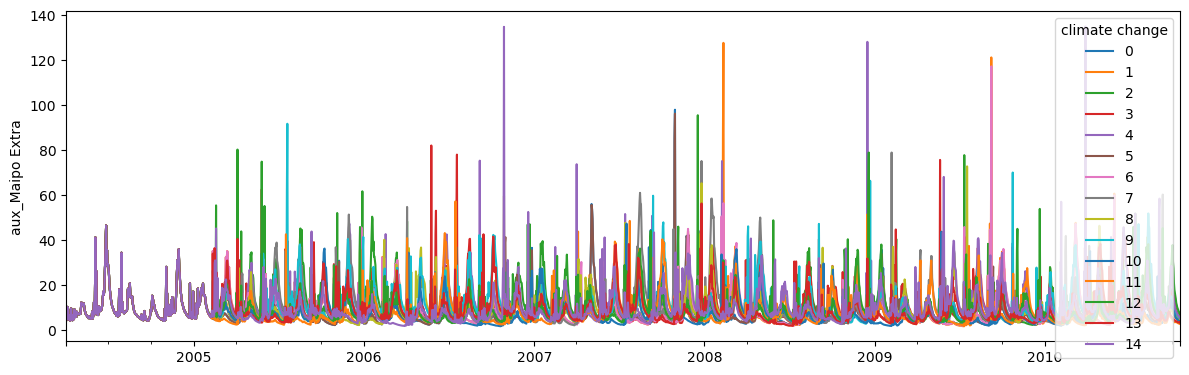

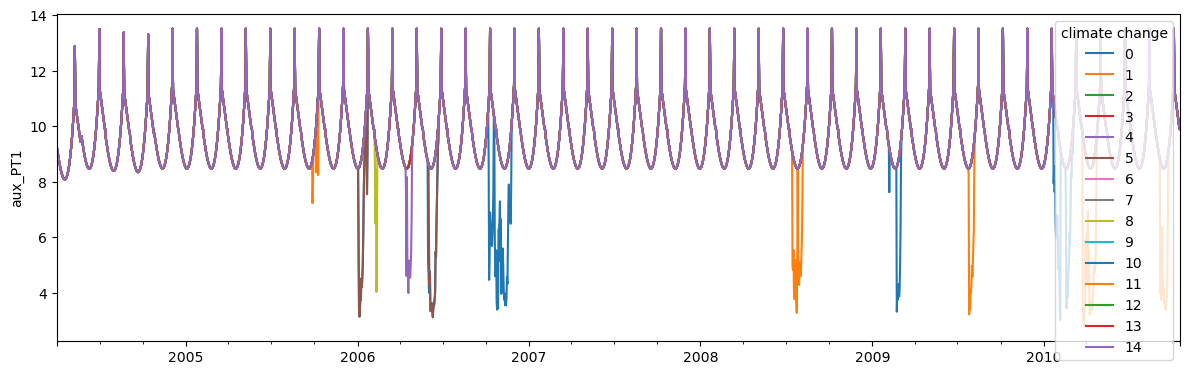

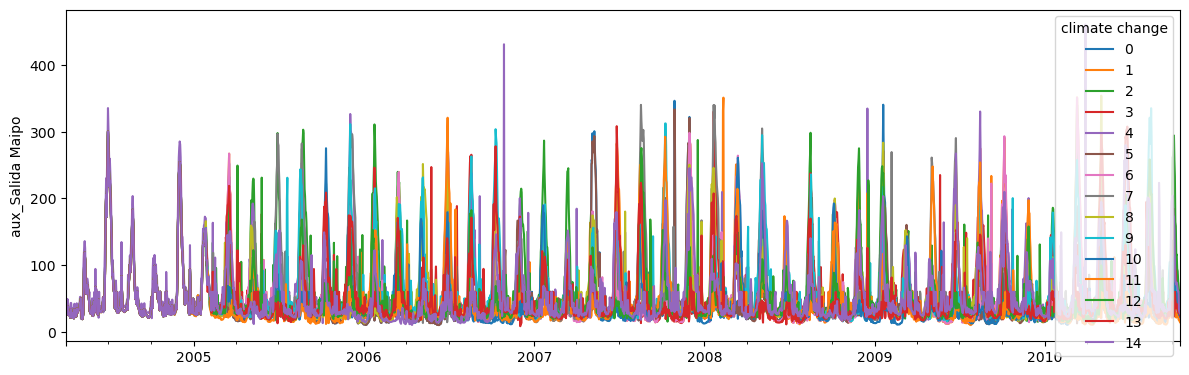

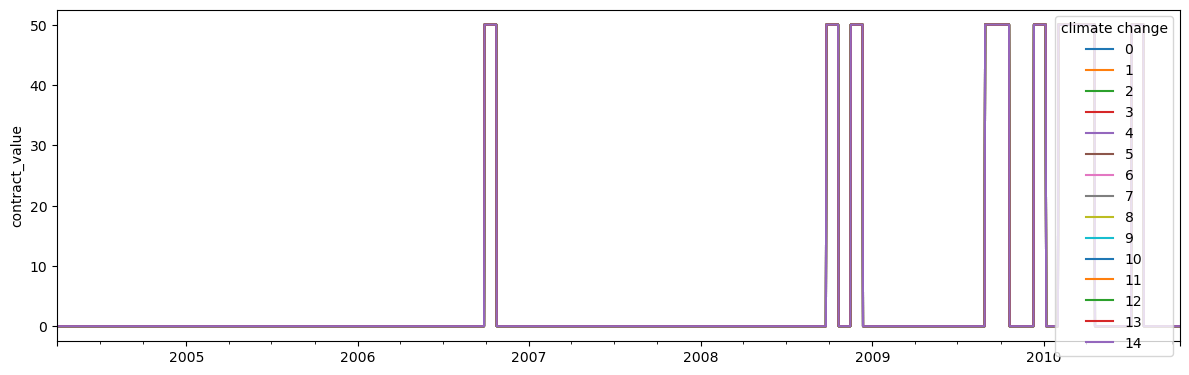

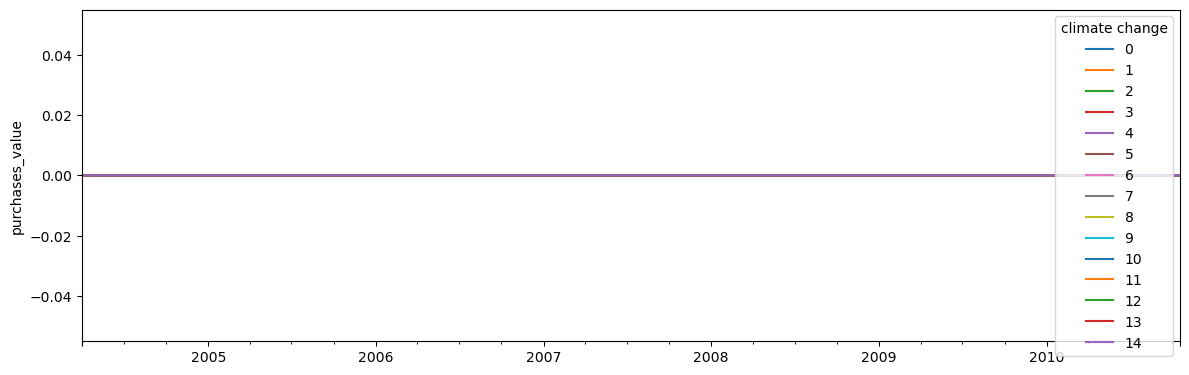

In [12]:
from datetime import timedelta

with tables.open_file(os.path.join(OUTPUT_DIR, 'flows.h5')) as h5:
    tbl = h5.get_node('/time')
    date_index = pandas.to_datetime({k: tbl.col(k) for k in ('year', 'month', 'day')})
    
    data = {}
    for ca in h5.walk_nodes('/', 'CArray'):
        data[ca._v_name] = pandas.DataFrame(ca.read(), index=date_index, columns=m.scenarios.multiindex)


df = pandas.concat(data, axis=1)
nrows = len(df.columns.levels[0])


#df.plot(subplots=True, )
FLOW_UNITS = 'Mm^3/day'


Y_LABEL_MAP = {
    # You can fill this if you want to write your own y-labels
    # CHECK THE UNITS?
    "Embalse": f"Embalse Volume [${FLOW_UNITS}$]"
}


for node in df.columns.levels[0]:
    fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
    df[node].plot(ax=ax)
    
    try:
        label = Y_LABEL_MAP[node]
    except KeyError:
        label = node
    
    ax.set_ylabel(label)
    plt.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f'{node}.png'), dpi=300)
    

